In [1]:
%cd /content
!git clone https://04edf789c52e5b4930be3bbccb51899d47c5a40a@github.com/shonenkov/StackMix-OCR.git
%cd /content/StackMix-OCR

/content
/content/StackMix-OCR


In [2]:
DATA_DIR = '../StackMix-OCR-DATA'
MWE_TOKENS_DIR = '../StackMix-OCR-MWE_TOKENS'

DATASET_NAME = 'peter'  # iam|peter|saintgall|iam_tbluche|hkr|bentham
IMAGE_H = 128
IMAGE_W = {'peter': 1024}.get(DATASET_NAME, 2048)

In [3]:
!python scripts/download_dataset.py --dataset_name '{DATASET_NAME}'

In [4]:
!python scripts/download_dataset.py --dataset_name corpora

In [5]:
!python scripts/prepare_stackmix.py \
  --dataset_name "{DATASET_NAME}" \
  --data_dir "../StackMix-OCR-DATA" \
  --mwe_tokens_dir "../StackMix-OCR-MWE_TOKENS" \
  --image_w "{IMAGE_W}" \
  --image_h "{IMAGE_H}"

In [6]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
from src.stackmix import StackMix
from configs import CONFIGS
from src.ctc_labeling import CTCLabeling
import json
import random
import math
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
stackmix = StackMix(
    mwe_tokens_dir=MWE_TOKENS_DIR,
    data_dir=DATA_DIR,
    dataset_name=DATASET_NAME,
    image_h=IMAGE_H,
    p_background_smoothing=1.0
)
stackmix.load()

In [8]:
config = CONFIGS[DATASET_NAME](DATA_DIR, '', '')
ctc_labeling = CTCLabeling(config)
stackmix.load_corpus(ctc_labeling, f'{DATA_DIR}/corpora/{config.corpus_name}')

100%|██████████| 2318058/2318058 [01:32<00:00, 25011.36it/s]


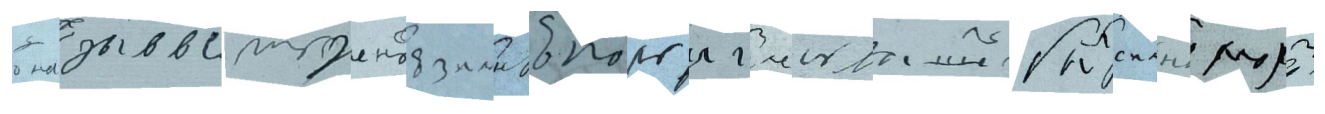

In [9]:
t = 'Однажды в студеную зимнюю пору я из лесу вышел был сильный мороз'.lower()
img = stackmix.run_stackmix(t)

plt.figure(num=None, figsize=(14, 14), dpi=120, facecolor='w', edgecolor='k');
plt.imshow(img);
plt.axis(False);

In [10]:
text_rus = '''Однажды в студеную зимнюю пору я из лесу вышел был сильный мороз'''

In [11]:
def get_bin_mask(image):
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3, mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    kernel = np.ones((2,2),np.uint8)
    mask = ~mask.astype(np.bool)

    bg = np.ones(image.shape, dtype=np.uint8) * 255
    bg[mask] = image[mask].copy()

    return bg

def run_stackmix(sm, text, tokenizer=None):
        if tokenizer is None:
            tokenizer = random.choices(
                population=[
                    sm.tokenizers[3],
                    sm.tokenizers[4],
                    sm.tokenizers[5],
                    sm.tokenizers[6],
                    sm.tokenizers[7],
                    sm.tokenizers[8],
                ],
                weights=[0.05, 0.15, 0.20, 0.20, 0.20, 0.20],
                k=1
            )[0]

        image, left_x = None, None

        spans = sm.get_spans(text, tokenizer)
        if not sm.check_spans(spans):
            return

        for span in spans:
            word_token, (span_a, span_b), token = span
            if image is None:
                path = random.choice(sm.token2path.loc[word_token]['path'])
                image = cv2.imread(path)
                left_x = sm.path2leftx.loc[path]['left_x']
            else:
                path = random.choice(sm.token2path.loc[word_token]['path'])
                stack_image = cv2.imread(path)
      
                stack_left_x = sm.path2leftx.loc[path]['left_x']
                image = sm.stack_images(image, stack_image, sm.angle, stack_left_x)
                left_x = stack_left_x 

        return image

def resize_if_need(image, max_h, max_w):
    img = image.copy()
    img_h, img_w, img_c = img.shape
    coef = 1 if img_h <= max_h and img_w <= max_w else max(img_h / max_h, img_w / max_w)
    h = int(img_h / coef)
    w = int(img_w / coef)
    img = cv2.resize(img, (w, h))
    return img
    
def make_img_padding(image, max_h, max_w):
    img = image.copy()
    img_h, img_w, img_c = img.shape
    bg = np.ones((max_h, max_w, img_c), dtype=np.uint8)*255
    x1 = (max_w - img_w) // 2
    y1 = (max_h - img_h) // 2
    x2 = x1 + img_w
    y2 = y1 + img_h
    bg[y1:y2, x1:x2, :] = img.copy()
    return bg

def get_text_mask(image):
    img = image.copy()
    COLOR_MIN = np.array([0, 0, 0],np.uint8)
    COLOR_MAX = np.array([255, 255, 150],np.uint8)

    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    text_mask = cv2.inRange(img, COLOR_MIN, COLOR_MAX).astype(bool)

    return text_mask

def calc_mask_mean(images, index, window):
    img = np.zeros(images[0].shape, dtype=np.float32)
    img_count = 0
    for i in range(index - window, index):
        img += images[i]
        img_count += 1
        
    img = img / img_count
    img = np.clip(img, 0, 255)
    img = img.astype(np.uint8)
    return img

def smash_color(image, color_min, color_max):
    out_img = image.copy()

    out_img = cv2.cvtColor(out_img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(out_img, color_min, color_max)
    out_img = cv2.cvtColor(out_img, cv2.COLOR_HSV2RGB)
    bool_mask = mask.astype(bool)

    white_bg = np.ones(out_img.shape, dtype=np.uint8) * 255

    white_bg[bool_mask] = out_img[bool_mask]

    w = 32 
    steps = out_img.shape[1] // w
    micro_step = out_img.shape[1] % w

    img_parts = [white_bg[:, i*w:i*w + w] for i in range(steps)]

    background = np.zeros(out_img.shape, dtype=np.uint8)
    
    for i in range(steps):
        background[:, i*w:i*w + w] = calc_mask_mean(img_parts, i, steps)

    background[:, -1 * micro_step:, :] = white_bg[:, -1 * micro_step:, :]
    
    out_img[bool_mask] = background[bool_mask]

    return out_img

def get_text_from_image(img):
    COLOR_MIN = np.array([0, 0, 0],np.uint8)
    COLOR_MAX = np.array([250,250,150],np.uint8)
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    text_mask = cv2.inRange(img, COLOR_MIN, COLOR_MAX).astype(bool)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

    bg = np.ones(img.shape, dtype=np.uint8) * 255
    bg[text_mask] = img[text_mask]
    return bg

def prepare_text(text):
    drop_chars = ['.', ',', ';', ':', '-', '«', '»',]
    text = text.translate({ord(x): '' for x in drop_chars})
    return text.lower()

def show_image(image):
    img = image.copy()
    plt.figure(figsize=(14, 14), dpi=300);
    plt.imshow(img);
    plt.axis(False);
    plt.show();

однажды в студеную зимнюю пору я из лесу вышел был сильный мороз


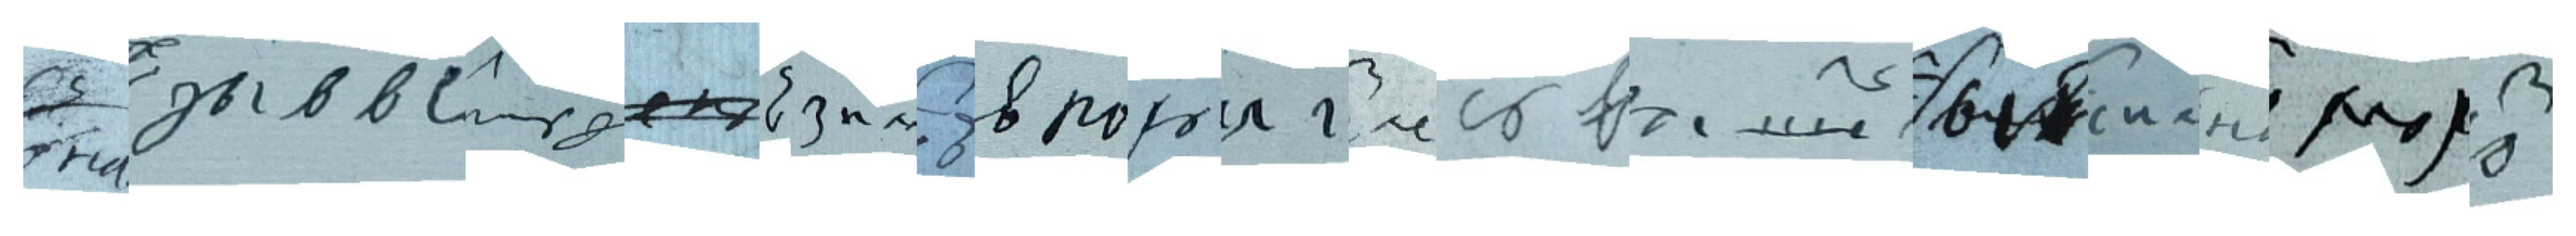

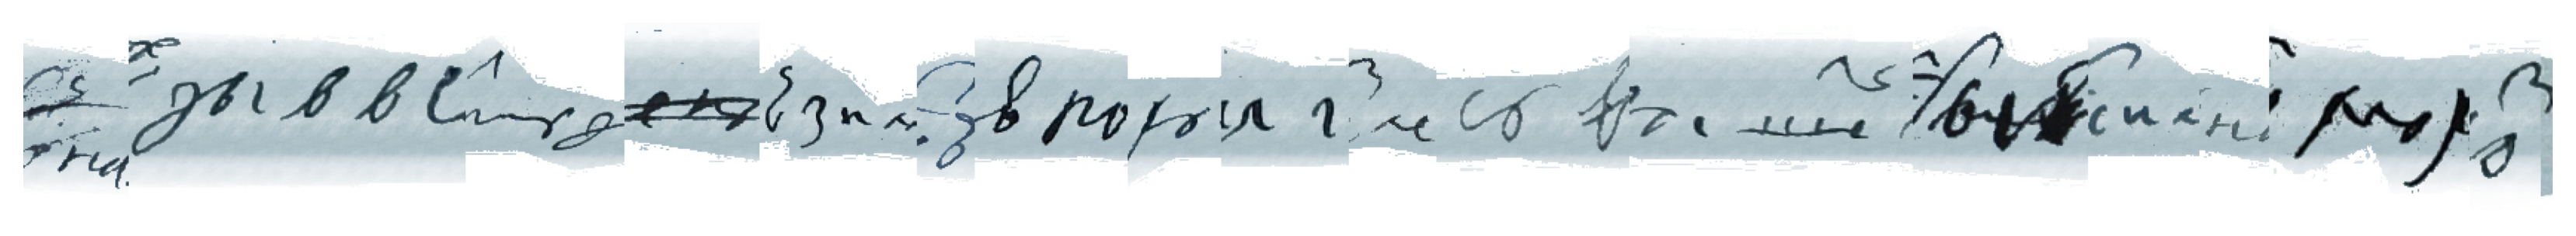

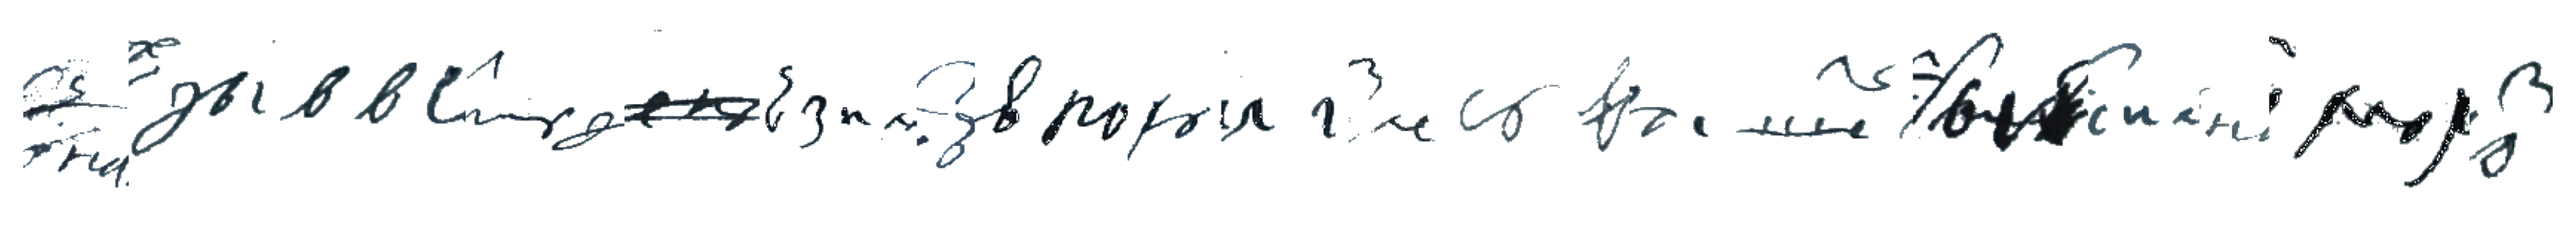

In [15]:
p_text = prepare_text(text_rus)
print(p_text)

img = run_stackmix(stackmix, p_text, tokenizer=None)
show_image(img)

color_min = np.array([70, 2, 160],np.uint8)
color_max = np.array([140, 255, 255],np.uint8)

img = smash_color(img, color_min, color_max)
show_image(img)

img = get_text_from_image(img)
show_image(img)